In [53]:
import pandas as pd

# COVID-19

In [54]:
# Read

In [55]:
data = pd.read_csv('latest.csv')

In [56]:
data.Region.unique()

array(['NAYARIT', 'VERACRUZ', 'AGUASCALIENTES', 'MÉXICO', 'GUANAJUATO',
       'BAJA CALIFORNIA', 'CIUDAD DE MÉXICO', 'COAHUILA', 'SINALOA',
       'CHIAPAS', 'YUCATÁN', 'MORELOS', 'NUEVO LEÓN', 'QUERÉTARO',
       'PUEBLA', 'DURANGO', 'JALISCO', 'QUINTANA ROO', 'CAMPECHE',
       'SAN LUIS POTOSÍ', 'GUERRERO', 'OAXACA', 'CHIHUAHUA', 'COLIMA',
       'SONORA', 'TAMAULIPAS', 'HIDALGO', 'TABASCO', 'MICHOACAN',
       'BAJA CALIFORNIA SUR', 'ZACATECAS', 'TLAXCALA'], dtype=object)

In [57]:
data.isnull().head(), data.isnull().tail()

(   Date_Confirmed  Date_Symptoms  Region  Region_ID  Region_Key  Origin
 0           False          False   False      False       False   False
 1           False          False   False      False       False   False
 2           False          False   False      False       False   False
 3           False          False   False      False       False   False
 4           False          False   False      False       False   False,
        Date_Confirmed  Date_Symptoms  Region  Region_ID  Region_Key  Origin
 20232           False          False   False      False       False   False
 20233           False          False   False      False       False   False
 20234           False          False   False      False       False   False
 20235           False          False   False      False       False   False
 20236           False          False   False      False       False   False)

In [58]:
data.isnull().values.any()

False

In [59]:
data.isnull().values.sum()

0

In [60]:
#To use symptoms as indicator, uncomment the next two lines:
#data = data.drop(['Date_Confirmed'], axis=1)
#data = data.rename(columns={'Date_Symptoms':'Date_Confirmed'}) # Rename index

In [61]:
# Totals and delta

In [62]:
    # Region delta (ie, new cases)
cum_df = (data.groupby(['Region','Date_Confirmed'])['Date_Confirmed'].count()).to_frame()

In [63]:
    # Rename because duplicate index
cum_df['Region_Delta'] = cum_df['Date_Confirmed']

In [64]:
    # Region cumulative by date
cum_df['Region_Cumulative'] = cum_df.groupby(['Region'])['Region_Delta'].cumsum()

In [65]:
    # Clean up
cum_df = cum_df.drop(['Date_Confirmed'], axis=1)

In [66]:
# To view full table:
# from IPython.core.display import HTML
# display(HTML(cum_df.to_html()))

# Tables

In [67]:
# Read

In [68]:
pivot_tbl_cum = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.reset_index()
pivot_tbl_daily = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Delta').T.reset_index()

In [69]:
# Save

In [70]:
pivot_tbl_cum.to_csv('time_series/total-mexico-covid19.csv', index=False)
pivot_tbl_daily.fillna(0).to_csv('time_series/daily-mexico-covid19.csv', index=False)

In [71]:
# Set datetime

In [72]:
pivot_tbl_cum['Date_Confirmed'] = pd.to_datetime(pivot_tbl_cum.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_cum['Date_Confirmed'] = pivot_tbl_cum['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [73]:
# Set datetime

In [74]:
pivot_tbl_daily['Date_Confirmed'] = pd.to_datetime(pivot_tbl_daily.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_daily['Date_Confirmed'] = pivot_tbl_daily['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [75]:
# Set index

In [76]:
pivot_tbl_cum = pivot_tbl_cum.set_index(pd.DatetimeIndex(pivot_tbl_cum['Date_Confirmed']))
pivot_tbl_daily = pivot_tbl_daily.set_index(pd.DatetimeIndex(pivot_tbl_daily['Date_Confirmed']))

# Plots

In [77]:
from numpy import *
import math
import matplotlib.pyplot as plt

### Confirmed cases

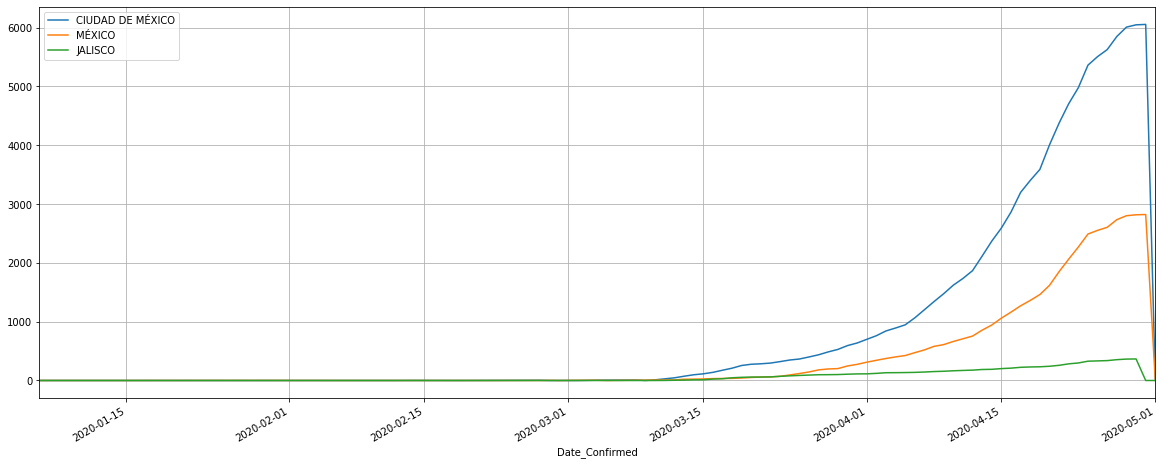

In [78]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'MÉXICO', 'JALISCO',]:
    pivot_tbl_cum[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

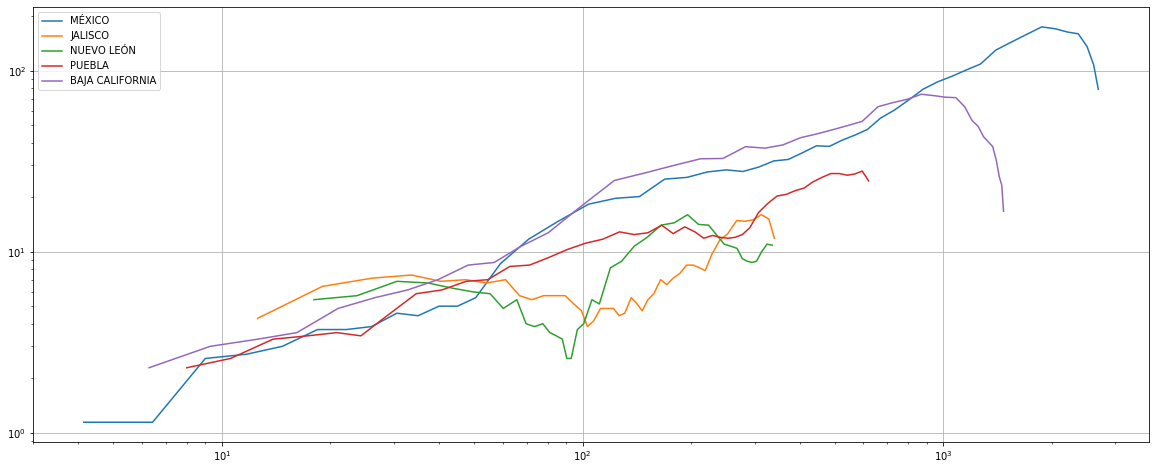

In [79]:
plt.figure(figsize=(20,8))

for state in ['MÉXICO', 'JALISCO', 'NUEVO LEÓN', 'PUEBLA', 'BAJA CALIFORNIA']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label=state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

In [80]:
# Needs fix

# Starting at date w/certain number of cases
def select_min_cases(df, min):
    df2_state = []
    df2_date= []
    df2_cases= []
    for state in df.columns:
        #print(df.columns)
        for index in range(len(df[state])):
            if df[state][index] >= min:
                #print(state)
                #print(df[state].index[index])
                #print((df[state][index]))
                df2_state.append(state)
                df2_date.append(df[state].index[index])
                df2_cases.append(df[state][index])
            #if df[state][index] < num:
                #print(None)
    my_df = pd.DataFrame({'Region': pd.Series(df2_state), 'Date_Confirmed': pd.Series(df2_date), 'Region_Cumulative': pd.Series(df2_cases)})
    #my_df = my_df.set_index(['Region','Date_Confirmed'])
    return my_df

min_cases = select_min_cases(pivot_tbl_cum, 15).reset_index()
min_cases = min_cases.drop(['index'], axis=1).reset_index()
min_cases = min_cases.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.sort_index()
min_cases = min_cases.fillna(method='ffill')
daily_min_cases = min_cases.diff()

plt.figure(figsize=(20,8))

for state in ['CDMX', 'JALISCO', 'NUEVO LEON']:
    daily_min_cases[state].fillna(0).rolling(window=7).mean().plot()
    
plt.legend()
plt.grid(True)
plt.show()

TypeError: '>=' not supported between instances of 'str' and 'int'

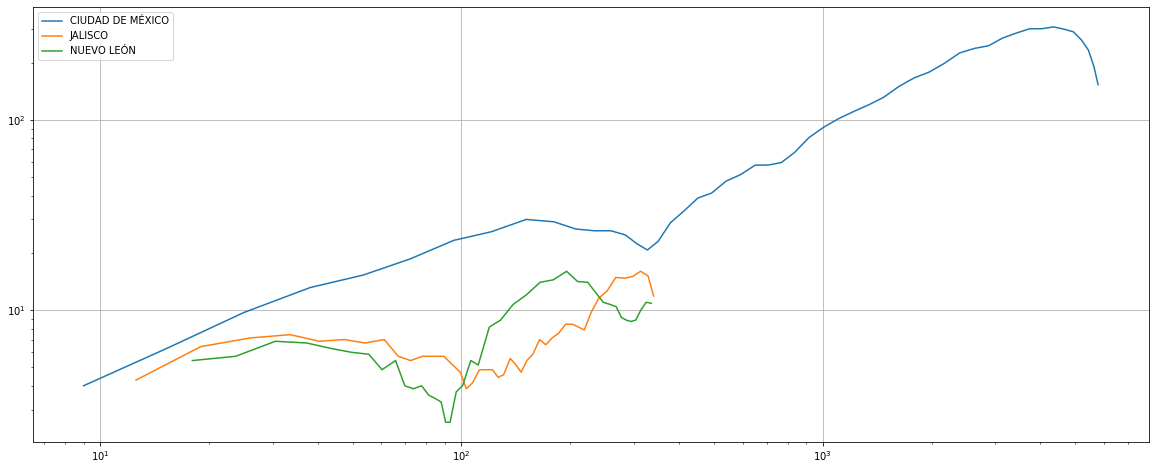

In [81]:
plt.figure(figsize=(20,8))

for state in ['CIUDAD DE MÉXICO', 'JALISCO', 'NUEVO LEÓN']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label = state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

In [84]:
### Dayweek of reporting

In [85]:
test = pivot_tbl_daily

In [86]:
import janitor

In [126]:
# sunday
abr_26 = test.filter_date('Date_Confirmed','2020-02-01','2020-04-26')

In [127]:
# monday
abr_27 = test.filter_date('Date_Confirmed','2020-02-01','2020-04-27')

In [128]:
# bar chart

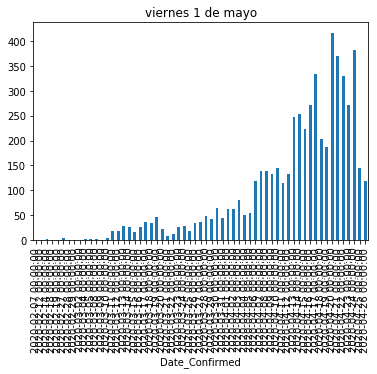

In [129]:
abr_26['CIUDAD DE MÉXICO'].plot(kind='bar', title='viernes 1 de mayo')